In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import time
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFECV
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from joblib import dump, load


# 1 - Dados

In [148]:
rain_data = pd.read_pickle('rain_data_aed.pkl')
rain_data.head()

,date,location,mintemp,rainfall,humidity9am,humidity3pm,cloud9am,cloud3pm,raintoday,raintomorrow,winddir3pm,winddir9am,windgustdir,windgustspeed,windspeed3pm,windspeed9am
0,2008-12-01,Albury,13.4,0.6,71.0,22.0,8.0,NaN,0.0,0,WNW,W,W,44.0,24.0,20.0
1,2008-12-02,Albury,7.4,0.0,44.0,25.0,NaN,NaN,0.0,0,WSW,NNW,WNW,44.0,22.0,4.0
2,2008-12-03,Albury,12.9,0.0,38.0,30.0,NaN,2.0,0.0,0,WSW,W,WSW,46.0,26.0,19.0
3,2008-12-04,Albury,9.2,0.0,45.0,16.0,NaN,NaN,0.0,0,E,SE,NE,24.0,9.0,11.0
4,2008-12-05,Albury,17.5,1.0,82.0,33.0,7.0,8.0,0.0,0,NW,ENE,W,41.0,20.0,7.0


In [149]:
rain_data.columns

Index(['date', 'location', 'mintemp', 'rainfall', 'humidity9am', 'humidity3pm',
       'cloud9am', 'cloud3pm', 'raintoday', 'raintomorrow', 'winddir3pm',
       'winddir9am', 'windgustdir', 'windgustspeed', 'windspeed3pm',
       'windspeed9am'],
      dtype='object')

# 2 - Split de treino e teste

In [150]:
X = rain_data.drop(['raintomorrow','date'], axis=1)
y = rain_data['raintomorrow']

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [152]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99535 entries, 95444 to 43567
Data columns (total 14 columns):
location         99535 non-null object
mintemp          99116 non-null float64
rainfall         98562 non-null float64
humidity9am      98271 non-null float64
humidity3pm      97000 non-null float64
cloud9am         61868 non-null float64
cloud3pm         59528 non-null float64
raintoday        98562 non-null float64
winddir3pm       96904 non-null object
winddir9am       92546 non-null object
windgustdir      93057 non-null object
windgustspeed    93091 non-null float64
windspeed3pm     97699 non-null float64
windspeed9am     98595 non-null float64
dtypes: float64(10), object(4)
memory usage: 11.4+ MB


# 3 - Tratando as variáveis categóricas com nulos

In [153]:
categorical=list(X.columns[X.dtypes == 'object'])
categorical

['location', 'winddir3pm', 'winddir9am', 'windgustdir']

In [154]:
X[categorical].isnull().sum()

location           0
winddir3pm      3778
winddir9am     10013
windgustdir     9330
dtype: int64

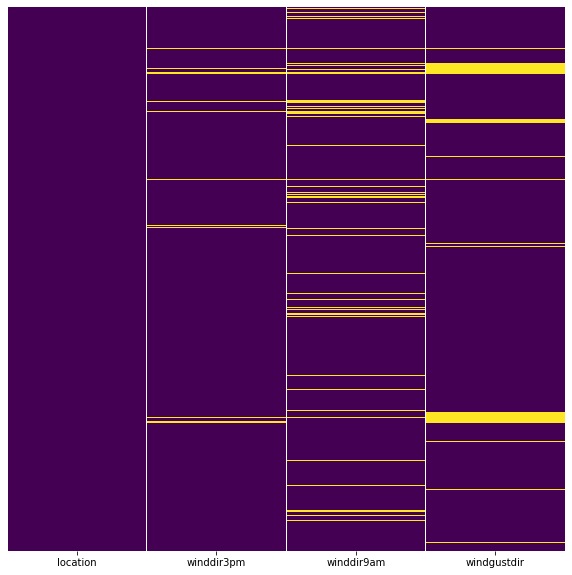

In [155]:
plt.figure(figsize=(10,10))
sns.heatmap(X[categorical].isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Substituindo os valores nulos de cada coluna pelo valor que mais se repete nela

In [156]:
for data in [X_train, X_test]:
    for col in categorical[1:]:
        col_mode=X_train[col].mode()[0]
        data[col].fillna(col_mode, inplace=True)
        

C:\Users\titow\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



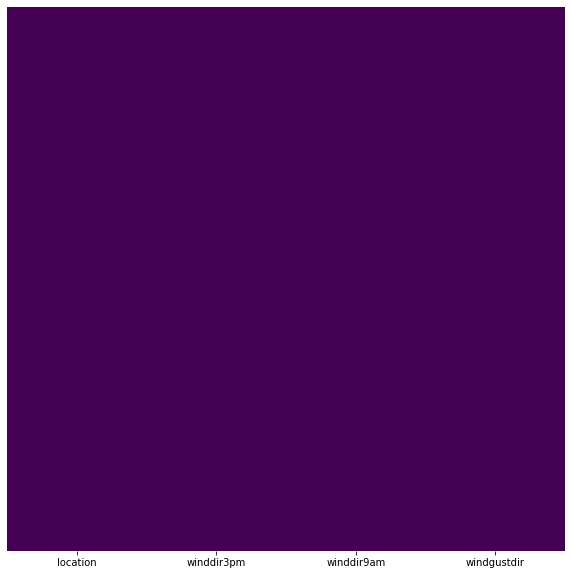

In [157]:
plt.figure(figsize=(10,10))
sns.heatmap(X_train[categorical].isnull(),yticklabels=False,cbar=False,cmap='viridis')

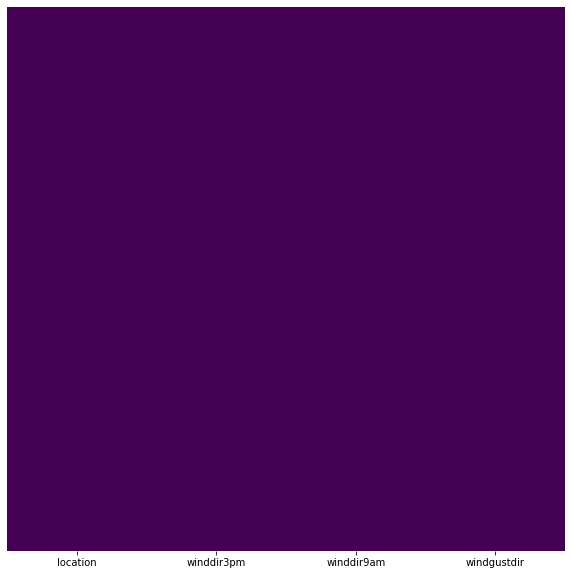

In [158]:
plt.figure(figsize=(10,10))
sns.heatmap(X_test[categorical].isnull(),yticklabels=False,cbar=False,cmap='viridis')

# 4 - Tratando as variáveis numéricas com nulos

In [159]:
numerical=list(X.columns[X.dtypes == 'float64'])
numerical

['mintemp',
 'rainfall',
 'humidity9am',
 'humidity3pm',
 'cloud9am',
 'cloud3pm',
 'raintoday',
 'windgustspeed',
 'windspeed3pm',
 'windspeed9am']

In [160]:
X[numerical].isnull().sum()

mintemp            637
rainfall          1406
humidity9am       1774
humidity3pm       3610
cloud9am         53657
cloud3pm         57094
raintoday         1406
windgustspeed     9270
windspeed3pm      2630
windspeed9am      1348
dtype: int64

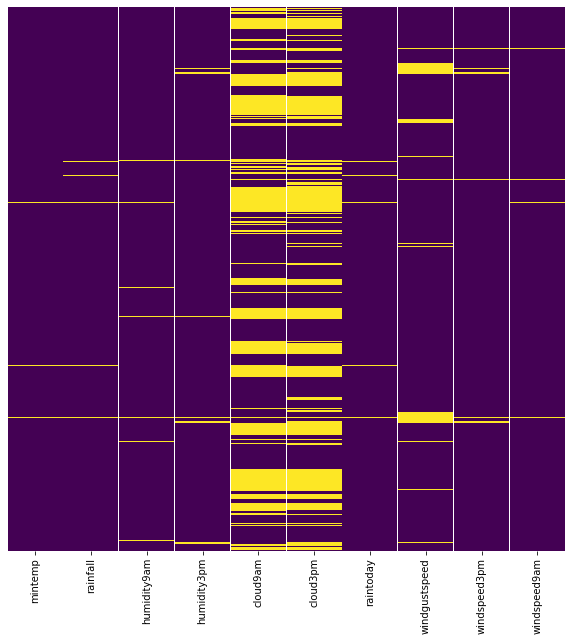

In [161]:
plt.figure(figsize=(10,10))
sns.heatmap(X[numerical].isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [163]:
X[numerical].describe()

,mintemp,rainfall,humidity9am,humidity3pm,cloud9am,cloud3pm,raintoday,windgustspeed,windspeed3pm,windspeed9am
count,141556.000000,140787.000000,140419.000000,138583.000000,88536.000000,85099.000000,140787.000000,132923.000000,139563.000000,140845.000000
mean,12.186400,2.349974,68.843810,51.482606,4.437189,4.503167,0.223423,39.984292,18.637576,14.001988
std,6.403283,8.465173,19.051293,20.797772,2.887016,2.720633,0.416541,13.588801,8.803345,8.893337
min,-8.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000
25%,7.600000,0.000000,57.000000,37.000000,1.000000,2.000000,0.000000,31.000000,13.000000,7.000000
50%,12.000000,0.000000,70.000000,52.000000,5.000000,5.000000,0.000000,39.000000,19.000000,13.000000
75%,16.800000,0.800000,83.000000,66.000000,7.000000,7.000000,0.000000,48.000000,24.000000,19.000000
max,33.900000,371.000000,100.000000,100.000000,9.000000,9.000000,1.000000,135.000000,87.000000,130.000000


### Pela grande diferença entre o terceiro quartil e o quarto, podemos notar que as colunas rainfall, humidity3pm, windgustspeed, windspeed3pm e windspeed9am possuem outliers

## Substituindo os valores nulos de cada coluna pela mediana por conta da existência de outliers

In [165]:
for data in [X_train, X_test]:
    for col in numerical:
        col_median=X_train[col].median()
        data[col].fillna(col_median, inplace=True)

C:\Users\titow\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



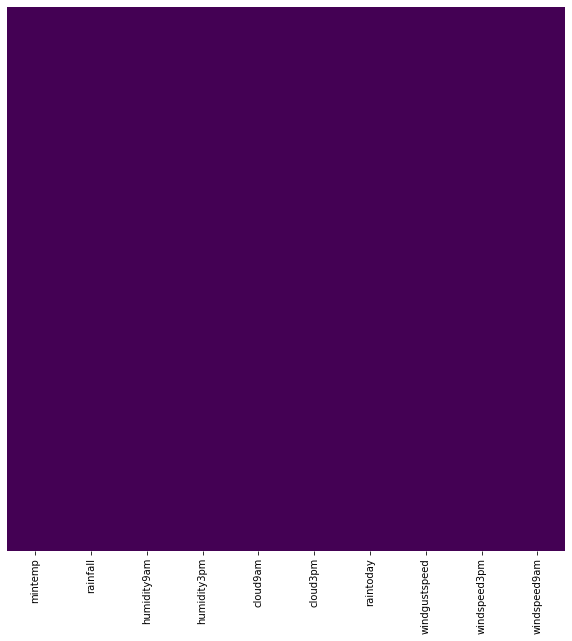

In [166]:
plt.figure(figsize=(10,10))
sns.heatmap(X_train[numerical].isnull(),yticklabels=False,cbar=False,cmap='viridis')

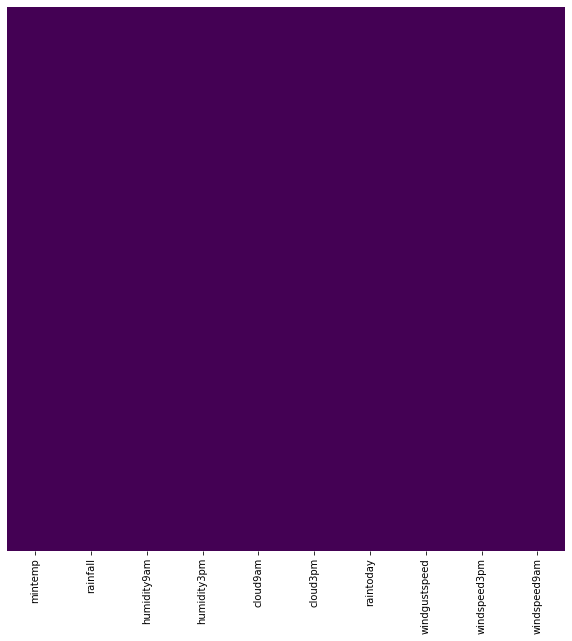

In [167]:
plt.figure(figsize=(10,10))
sns.heatmap(X_test[numerical].isnull(),yticklabels=False,cbar=False,cmap='viridis')

# 5 - Encode das variáveis

In [168]:
categorical

['location', 'winddir3pm', 'winddir9am', 'windgustdir']

In [169]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99535 entries, 95444 to 43567
Data columns (total 14 columns):
location         99535 non-null object
mintemp          99535 non-null float64
rainfall         99535 non-null float64
humidity9am      99535 non-null float64
humidity3pm      99535 non-null float64
cloud9am         99535 non-null float64
cloud3pm         99535 non-null float64
raintoday        99535 non-null float64
winddir3pm       99535 non-null object
winddir9am       99535 non-null object
windgustdir      99535 non-null object
windgustspeed    99535 non-null float64
windspeed3pm     99535 non-null float64
windspeed9am     99535 non-null float64
dtypes: float64(10), object(4)
memory usage: 11.4+ MB


In [170]:
X_train[categorical].head()

,location,winddir3pm,winddir9am,windgustdir
95444,Adelaide,SW,NNE,W
27932,Richmond,SE,NNE,SSW
15097,Newcastle,NW,NW,W
94607,Adelaide,NW,N,NW
99888,MountGambier,SW,NNW,WSW


## Usando a técnica de dummy variables pra fazer o encode

In [171]:
X_train = pd.concat([X_train[numerical],
                     pd.get_dummies(X_train['location']), 
                     pd.get_dummies(X_train['windgustdir']),
                     pd.get_dummies(X_train['winddir9am']),
                     pd.get_dummies(X_train['winddir3pm'])], axis=1)

In [172]:
X_train.head()

,mintemp,rainfall,humidity9am,humidity3pm,cloud9am,cloud3pm,raintoday,windgustspeed,windspeed3pm,windspeed9am,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
95444,13.0,14.0,89.0,70.0,5.0,5.0,1.0,31.0,17.0,6.0,...,0,0,0,0,0,0,1,0,0,0
27932,19.5,24.6,99.0,83.0,5.0,5.0,1.0,35.0,0.0,13.0,...,0,0,0,1,0,0,0,0,0,0
15097,21.0,0.0,26.0,17.0,0.0,0.0,0.0,39.0,19.0,4.0,...,0,1,0,0,0,0,0,0,0,0
94607,10.3,4.8,78.0,50.0,5.0,5.0,1.0,54.0,20.0,9.0,...,0,1,0,0,0,0,0,0,0,0
99888,15.5,0.2,80.0,77.0,8.0,6.0,0.0,31.0,20.0,4.0,...,0,0,0,0,0,0,1,0,0,0


In [173]:
X_test = pd.concat([X_test[numerical], 
                     pd.get_dummies(X_test['location']), 
                     pd.get_dummies(X_test['windgustdir']),
                     pd.get_dummies(X_test['winddir9am']),
                     pd.get_dummies(X_test['winddir3pm'])], axis=1)

In [174]:
X_test.head()

,mintemp,rainfall,humidity9am,humidity3pm,cloud9am,cloud3pm,raintoday,windgustspeed,windspeed3pm,windspeed9am,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
86232,17.4,0.0,63.0,61.0,1.0,0.0,0.0,33.0,19.0,11.0,...,0,0,0,0,0,0,0,0,0,0
57576,6.8,0.8,80.0,55.0,5.0,4.0,0.0,46.0,22.0,17.0,...,0,0,1,0,0,0,0,0,0,0
124071,10.1,14.6,70.0,61.0,5.0,5.0,1.0,31.0,9.0,13.0,...,0,0,0,0,1,0,0,0,0,0
117955,14.4,0.0,40.0,23.0,1.0,0.0,0.0,41.0,17.0,9.0,...,0,0,0,0,0,0,1,0,0,0
133468,6.8,10.0,92.0,47.0,7.0,1.0,1.0,28.0,13.0,15.0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
X_test.shape

(42658, 107)

In [176]:
X_train.shape

(99535, 107)

# 6 - Normalizando os dados

## Usarei o min-max scalar

In [177]:
scaler=MinMaxScaler()

normalized_data_train = scaler.fit_transform(X_train)
X_train.at[:] = normalized_data_train

normalized_data_test = scaler.transform(X_test)
X_test.at[:] = normalized_data_test

In [179]:
X_train.describe()

,mintemp,rainfall,humidity9am,humidity3pm,cloud9am,cloud3pm,raintoday,windgustspeed,windspeed3pm,windspeed9am,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
count,99535.000000,99535.000000,99535.000000,99535.000000,99535.000000,99535.000000,99535.000000,99535.000000,99535.000000,99535.000000,...,99535.000000,99535.000000,99535.000000,99535.000000,99535.000000,99535.000000,99535.000000,99535.000000,99535.000000,99535.000000
mean,0.484175,0.006222,0.688798,0.514954,0.517016,0.587680,0.220827,0.262580,0.224181,0.107549,...,0.054594,0.060210,0.067233,0.101180,0.064319,0.056814,0.064379,0.069172,0.060461,0.065324
std,0.151780,0.022529,0.189450,0.205232,0.254834,0.264874,0.414806,0.101658,0.104757,0.067923,...,0.227187,0.237877,0.250426,0.301569,0.245322,0.231488,0.245429,0.253747,0.238340,0.247098
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.375297,0.000000,0.570000,0.370000,0.333333,0.500000,0.000000,0.193798,0.156627,0.053846,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.479810,0.000000,0.700000,0.520000,0.555556,0.625000,0.000000,0.255814,0.228916,0.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.593824,0.001617,0.830000,0.650000,0.666667,0.750000,0.000000,0.310078,0.289157,0.146154,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [180]:
X_test.describe()

,mintemp,rainfall,humidity9am,humidity3pm,cloud9am,cloud3pm,raintoday,windgustspeed,windspeed3pm,windspeed9am,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
count,42658.000000,42658.000000,42658.000000,42658.000000,42658.000000,42658.000000,42658.000000,42658.000000,42658.000000,42658.000000,...,42658.000000,42658.000000,42658.000000,42658.000000,42658.000000,42658.000000,42658.000000,42658.000000,42658.000000,42658.000000
mean,0.484317,0.006388,0.688079,0.514965,0.515691,0.588187,0.222115,0.263802,0.225678,0.107834,...,0.053894,0.058020,0.068123,0.102443,0.064232,0.055207,0.065029,0.070936,0.061841,0.066271
std,0.151703,0.023135,0.189034,0.205536,0.255150,0.264778,0.415673,0.102344,0.105825,0.068476,...,0.225811,0.233783,0.251960,0.303233,0.245168,0.228386,0.246580,0.256721,0.240869,0.248759
min,-0.007126,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.007752,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.375297,0.000000,0.570000,0.370000,0.333333,0.500000,0.000000,0.193798,0.156627,0.053846,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.479810,0.000000,0.700000,0.520000,0.555556,0.625000,0.000000,0.255814,0.228916,0.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.593824,0.001617,0.830000,0.650000,0.666667,0.750000,0.000000,0.310078,0.289157,0.146154,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.952494,0.990836,1.000000,1.000000,1.000000,1.125000,1.000000,0.961240,1.048193,0.669231,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 7 - Modelos

In [181]:
dict_classifiers = {"Floresta Aleatória": RandomForestClassifier(random_state=0),
    "Vizinhos mais próximos": KNeighborsClassifier(),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=0),
    "Naive Bayes": GaussianNB(),
    "Regressão Logística": LogisticRegression(solver = "liblinear",random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
}

In [182]:
classifiers_names = list(dict_classifiers.keys())

In [183]:
classifiers_values=list(dict_classifiers.values())

In [184]:
def train_model(model):
    t0 = time.time()
    model.fit(X_train,y_train)
    tf = time.time()
    times=tf-t0
    print('Treinou em {:.3f} segundos '.format(times))
    prec = float("{0:.3f}".format(model.score(X_test,y_test)))
    print("Precisao = ",prec)
    
    return prec,times

### A célula abaixo demora aproximadamente 5 minutos para ser executada

In [114]:
times,precs = [],[]
for key,value in zip(classifiers_names,classifiers_values):
    print('------------------{}------------------'.format(key))
    prec,Time=train_model(value)
    precs.append(prec)
    times.append(Time)

------------------Floresta Aleatória------------------
Treinou em 25.121 segundos 
Precisao =  0.848
------------------Vizinhos mais próximos------------------
Treinou em 15.956 segundos 
Precisao =  0.822
------------------Árvore de Decisão------------------
Treinou em 3.163 segundos 
Precisao =  0.78
------------------Naive Bayes------------------
Treinou em 0.296 segundos 
Precisao =  0.635
------------------Regressão Logística------------------
Treinou em 0.862 segundos 
Precisao =  0.845
------------------Gradient Boosting------------------
Treinou em 31.679 segundos 
Precisao =  0.847


In [185]:
data_times = pd.DataFrame(index=classifiers_names,data=np.transpose([times,precs]),columns=['Tempo (seg)','Precisão'])
data_times

,Tempo (seg),Precisão
Floresta Aleatória,25.121,0.848
Vizinhos mais próximos,15.956,0.822
Árvore de Decisão,3.163,0.780
Naive Bayes,0.296,0.635
Regressão Logística,0.862,0.845
Gradient Boosting,31.679,0.847


In [116]:
fig = go.Figure([go.Bar(y=precs,x = classifiers_names,marker_color='red',text=precs,textposition='auto')]) 
fig.update_layout(title_text='Precisões dos Classificadores',xaxis_title="Classificador",yaxis_title="Precisão",xaxis_tickangle=-45)
fig.show()

In [117]:
times = np.round(times,3)
fig = go.Figure([go.Bar(y=times,x = classifiers_names,marker_color='blue',text=times,textposition='auto')]) 
fig.update_layout(title_text='Tempos dos Classificadores',xaxis_title="Classificador",yaxis_title="Tempo(seg)",xaxis_tickangle=-45)
fig.show()

## Levando em conta os tempos e as precisões, Regressão Logística foi o classificador que se saiu melhor

# 8 - Validação do Modelo

## Achando bons parâmetros 

### A célula abaixo demora aproximadamente 6 minutos para ser executada

In [119]:
model = LogisticRegression(solver = "liblinear",random_state=0)
parameters = [{'penalty':['l1','l2']}, {'C':[1, 10, 100, 1000]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', cv = 10, verbose=0)
grid_search.fit(X_train, y_train)


In [120]:
grid_search.best_estimator_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [121]:
model = grid_search.best_estimator_
model.fit(X_train,y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [122]:
model.score(X_test,y_test)

0.8453748417647334

## Validação Cruzada

In [123]:
scores = cross_val_score(model, X_train, y_train, cv = 10, scoring='accuracy')
scores

array([0.84458509, 0.83986337, 0.84197308, 0.84448463, 0.84629295,
       0.84055059, 0.84607656, 0.84778459, 0.84959309, 0.83874209])

In [124]:
scores.mean()

0.8439946026412546

## Conferindo se há overfitting

In [128]:
print('Score treino: {}'.format(model.score(X_train, y_train)))
print('Score teste: {}'.format(model.score(X_test, y_test)))

Score treino: 0.8442859295725121
Score teste: 0.8453748417647334


## Checando a Null accuracy

### Null accuracy é a precisão que pode ser atingida presumindo sempre a classe mais frequente 

In [129]:
accus=y_test.value_counts()
accus

0    33036
1     9622
Name: raintomorrow, dtype: int64

In [130]:
null_accuracy = (accus[0]/(accus[0]+accus[1]))
null_accuracy

0.7744385578320596

## Matriz de Confusão

In [131]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix

array([[31300,  1736],
       [ 4860,  4762]], dtype=int64)

In [193]:
print('True Negatives = ', conf_matrix[0,0])
print('True Positives = ', conf_matrix[1,1])
print('False Positives - Erro Tipo I = ', conf_matrix[0,1])
print('False Negatives - Erro Tipo II = ', conf_matrix[1,0])

True Negatives =  31300
True Positives =  4762
False Positives - Erro Tipo I =  1736
False Negatives - Erro Tipo II =  4860


### True Negative (TN): Não choveu e foi predito que não choveria.
###  True Positive (TP): Choveu e foi predito que choveria.
### False Negative (FN): Choveu e foi predito que não choveria.
### False Positive (FP): Não choveu e foi predito que choveria.

In [190]:
print('{} Amostras'.format(X_test.shape[0]))
print('{} Classificações corretas'.format(conf_matrix[0,0] + conf_matrix[1,1]))
print('{} Classificações incorretas'.format(conf_matrix[0,1] + conf_matrix[1,0]))

42658 Amostras
36062 Classificações corretas
6596 Classificações incorretas


In [196]:
 #TP/(TP + Fn)
4762/(4762+4860)

0.4949075036374974

## Classification Report

In [134]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.87      0.95      0.90     33036
           1       0.73      0.49      0.59      9622

    accuracy                           0.85     42658
   macro avg       0.80      0.72      0.75     42658
weighted avg       0.84      0.85      0.83     42658



### Precision: É uma medida da habilidade de um classificador de não dizer que uma label é positiva quando na verdade ela é negativa.
### Para cada classe é feita a razão: $\dfrac{TP}{TP+FP}$ 

### Recall: É uma medida da habilidade de um classificador de achar todas as instâncias positivas.
### Para cada classe é feita a razão: $\dfrac{TP}{TP+FN}$ 

### f1-score: É a média harmônica ponderada de precision e recall onde o melhor valor é 1 e o pior 0.
### Para cada classe é feita a razão: $\dfrac{2 * (recall * precision)}{(recall + precision)}$ 

# 9 - Salvando modelo

In [67]:
dump(model, 'modelo_logistic_regression.joblib') 

['modelo_logistic_regression.joblib']

In [337]:
#Model = load('modelo_logistic_regression.joblib')

# 10 - Preenchendo os dados originais com previsões

In [69]:
X = rain_data.drop(['raintomorrow','date'], axis=1)
y = rain_data['raintomorrow']

In [70]:
categorical = ['location', 'winddir3pm', 'winddir9am', 'windgustdir']

In [71]:
for col in categorical[1:]:
    col_mode=X[col].mode()[0]
    X[col].fillna(col_mode, inplace=True)

In [72]:
numerical=['mintemp','rainfall','humidity9am','humidity3pm','cloud9am','cloud3pm','raintoday','windgustspeed','windspeed3pm','windspeed9am']


In [73]:
for col in numerical:
    col_median=X[col].median()
    X[col].fillna(col_median, inplace=True)

In [74]:
X = pd.concat([X[numerical],
               pd.get_dummies(X['location']), 
               pd.get_dummies(X['windgustdir']),
               pd.get_dummies(X['winddir9am']),
               pd.get_dummies(X['winddir3pm'])], axis=1)



In [75]:
scaler=MinMaxScaler()

normalized_data = scaler.fit_transform(X)
X.at[:] = normalized_data


In [76]:
model_ = LogisticRegression(C=100,solver='liblinear',random_state=0)
model_.fit(X,y)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [77]:
y_pred_prob_total = model_.predict_proba(X)
y_pred_prob_total

array([[0.94459347, 0.05540653],
       [0.96696866, 0.03303134],
       [0.97181004, 0.02818996],
       ...,
       [0.98598642, 0.01401358],
       [0.96397818, 0.03602182],
       [0.98433921, 0.01566079]])

In [79]:
rain_data['prob_rain_tomorrow_modelo'] = y_pred_prob_total[:,1]

In [81]:
rain_data.to_csv('rain_data_com_probs.csv')